# IMU error

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
imu_df = pd.read_csv("imu_data.csv")
slam_df = pd.read_csv("slam_data.csv")

In [3]:
def calc_average_vel_imu(stamps: np.ndarray, velocities: np.ndarray) -> float:
    """Calculate the average velocity for the imu"""
    return velocities.mean()

def unnormalize_orientation(orientations: np.ndarray) -> np.ndarray:
    """The orientation data is unnormalized meaning that the values can be outside the range of [-pi, pi]."""
    orient_diffs = np.diff(orientations)
    normalization_steps = (np.abs(orient_diffs) >= np.pi).astype(int) * -np.sign(orient_diffs)
    return orientations + 2 * np.pi * np.insert(np.cumsum(normalization_steps), 0, 0)

### 1. Calculate the average velocity for the SLAM and the IMU

### 2. Calculate the biases and MSSDs

The **bias** is expressed as the factor with which the average velocity from the IMU differs from the average velocity SLAM.

$$bias = \frac{v_{avg,IMU} - v_{avg,SLAM}}{v_{avg,SLAM}}$$

The **variance** is estimate with the Mean Square Successive Difference (MSSD)

In [9]:
def calculate_bias(vel_imu: float, vel_slam: float) -> float:
    """Calculate the bias as a factor of the slam velocity"""
    # return (vel_imu - vel_slam) / vel_slam
    return (vel_imu - vel_slam) / vel_slam


def MSSD(values: np.ndarray) -> float:
    """Calculate the Mean Square Successive Difference (MSSD)"""
    return 0.5 * (np.sum((values[:-1] - values[1:]) ** 2) / (len(values) - 1)).astype(float)

In [15]:
%%timeit
np.diff(imu_df_part["stamps"])

17.4 µs ± 321 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [16]:
%%timeit
np.diff(imu_df_part["stamps"].to_numpy())

7.23 µs ± 60.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [22]:
np.sum(imu_df_part["angular velocities"].to_numpy()[1:] * np.diff(imu_df_part["stamps"].to_numpy())) / np.sum(np.diff(imu_df_part["stamps"].to_numpy()))


1.4959255764461235

In [34]:
# Iterate over the different experiments and calculate the bias and mssd for each one

results_dict = {
    "velocities": [],
    "biases": [],
    "mssds": [],
}
for number in pd.unique(imu_df["numbers"]):
    imu_df_part = imu_df[imu_df["numbers"] == number]
    slam_df_part = slam_df[slam_df["numbers"] == number]

    ### 1. Calculate the average velocity
    # imu average velocity
    avg_velocity_imu = imu_df_part["angular velocities"].mean()
    avg_velocity_imu = np.sum(imu_df_part["angular velocities"].to_numpy()[:-1] * np.diff(imu_df_part["stamps"].to_numpy())) / np.sum(np.diff(imu_df_part["stamps"].to_numpy()))
    # slam average velocity
    orients_unnorm = unnormalize_orientation(slam_df_part["orientations"].to_numpy())
    rotation = orients_unnorm[-1] - orients_unnorm[0]
    duration = slam_df_part["stamps"].iloc[-1] - slam_df_part["stamps"].iloc[0]
    avg_velocity_slam = rotation / duration

    results_dict['velocities'].append(avg_velocity_imu)

    ### 1B. use the total distance
    # avg_velocity_imu = np.sum(imu_df_part["angular velocities"].to_numpy()[1:] * np.diff(imu_df_part["stamps"].to_numpy()))
    # avg_velocity_slam = rotation
    # print(np.sum(np.diff(slam_df_part["orientations"].to_numpy())<0))

    ### 2. Calculate the biases and MSSDs
    bias = calculate_bias(avg_velocity_imu, avg_velocity_slam)
    mssd = MSSD(imu_df_part["angular velocities"].to_numpy())

    results_dict["biases"].append(bias)
    results_dict["mssds"].append(mssd)

results_df = pd.DataFrame.from_dict(results_dict)

results_df

,velocities,biases,mssds
0,0.306289,-0.168550,0.000435
1,0.472821,-0.178338,0.000363
2,0.646993,-0.186334,0.000610
3,0.800498,-0.195505,0.000586
4,0.973137,-0.194859,0.000984
5,1.145994,-0.148659,0.000997
6,1.321463,-0.168934,0.001572
7,1.491885,-0.181815,0.001974


### 3. Visualize

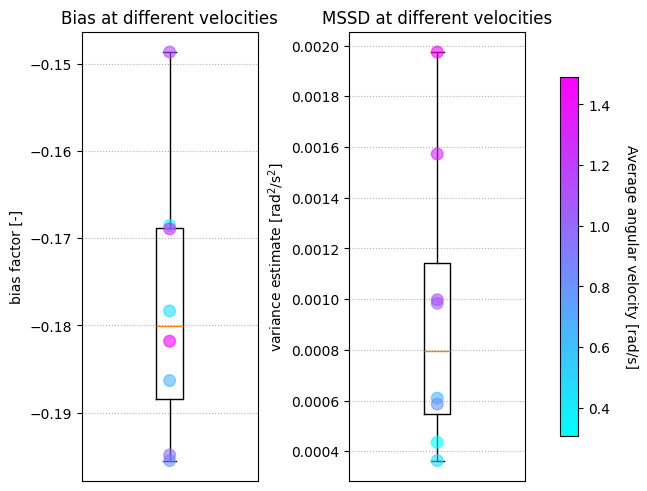

Bias (or calibration) factor: mean=-0.178; median=-0.180
Variance estimate: mean=0.00094; max=0.00197


In [39]:
fig, axs = plt.subplots(1, 2, layout="constrained")

velocities, biases, mssds = results_df["velocities"], results_df["biases"], results_df["mssds"]

ax = axs[0]
ax.boxplot(biases)
ax.scatter(np.full_like(biases, 1), biases, c=velocities, cmap="cool", zorder=10, s=70, alpha=0.6)
ax.set_ylabel("bias factor [-]")
ax.set_title("Bias at different velocities")
# ax.set_xticklabels(["bias"])
ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
# ax.set_xlabel("(a)")
ax.yaxis.grid(ls=":")

ax = axs[1]
# stds = np.sqrt(mssds)
ax.boxplot(mssds)
ax.scatter(np.full_like(mssds, 1), mssds, c=velocities, cmap="cool", zorder=10, s=70, alpha=0.6)
# ax.set_ylabel("angular velocity" + r"$^2$" +" [rad" + r"$^2$" + "/s" + r"$^2$" + "]")
ax.set_ylabel("variance estimate" + " [rad" + r"$^2$" + "/s" + r"$^2$" + "]")
ax.set_title("MSSD at different velocities")
# ax.set_xticklabels(["mssd"])
ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax.yaxis.grid(ls=":")

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(velocities.min(), velocities.max()), cmap="cool"),
    ax=ax,
    shrink=0.8,
    pad=0.2,
)
cbar.set_label("Average angular velocity [rad/s]", rotation=270, labelpad=20)

# plt.tight_layout()
plt.savefig("imu_error_fit.pdf", bbox_inches="tight")
plt.savefig("imu_error_fit.png", bbox_inches="tight")
plt.show()

print(f"Bias (or calibration) factor: mean={np.mean(biases):.3f}; median={np.median(biases):.3f}")
print(f"Variance estimate: mean={np.mean(mssds):.5f}; max={np.max(mssds):.5f}")